# Overfitting Solved
Using image augmentation and dropout, can we fix overfitting?

In [4]:
%load_ext nb_black
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import math
import os
import numpy as np
import matplotlib.pyplot as plt
import logging

logger = tf.get_logger()
logger.setLevel(logging.ERROR)

physical_devices = tf.config.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_devices[0], True)
print(physical_devices)

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


<IPython.core.display.Javascript object>

In [5]:
_URL = "https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip"
zip_dir = tf.keras.utils.get_file(
    "cats_and_dogs_filterted.zip", origin=_URL, extract=True
)
zip_dir_base = os.path.dirname(zip_dir)
base_dir = os.path.join(os.path.dirname(zip_dir), "cats_and_dogs_filtered")
train_dir = os.path.join(base_dir, "train")
validation_dir = os.path.join(base_dir, "validation")

train_cats_dir = os.path.join(
    train_dir, "cats"
)  # directory with our training cat pictures
train_dogs_dir = os.path.join(
    train_dir, "dogs"
)  # directory with our training dog pictures
validation_cats_dir = os.path.join(
    validation_dir, "cats"
)  # directory with our validation cat pictures
validation_dogs_dir = os.path.join(
    validation_dir, "dogs"
)  # directory with our validation dog pictures

num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val

<IPython.core.display.Javascript object>

In [1]:
BATCH_SIZE = 100
IMG_SHAPE = 150
class_names = ["Cat", "Dog"]
train_image_generator = ImageDataGenerator(
    rescale=1.0 / 255.0,
    horizontal_flip=True,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode="nearest",
)
validation_image_generator = ImageDataGenerator(rescale=1.0 / 255.0)

train_data_gen = train_image_generator.flow_from_directory(
    batch_size=BATCH_SIZE,
    directory=train_dir,
    shuffle=True,
    target_size=(IMG_SHAPE, IMG_SHAPE),
    class_mode="binary",
)
val_data_gen = train_image_generator.flow_from_directory(
    batch_size=BATCH_SIZE,
    directory=validation_dir,
    shuffle=False,
    target_size=(IMG_SHAPE, IMG_SHAPE),
    class_mode="binary",
)

NameError: name 'ImageDataGenerator' is not defined

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>], dtype=object)

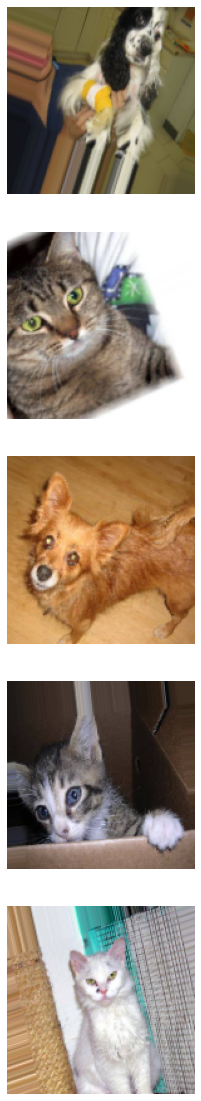

<IPython.core.display.Javascript object>

In [12]:
def plot_images(images):
    num_per_row = 5
    fig, axes = plt.subplots(
        num_per_row, math.ceil(len(images) / num_per_row), figsize=(20, 20)
    )
    for img, ax in zip(images, axes.flatten()):
        ax.imshow(img)
        ax.axis("off")
    return axes


augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plot_images(sample_training_images[:5])

In [20]:
model = tf.keras.Sequential(
    [
        tf.keras.layers.Conv2D(
            32,
            (3, 3),
            padding="same",
            activation=tf.nn.relu,
            input_shape=(IMG_SHAPE, IMG_SHAPE, 3),
        ),
        tf.keras.layers.MaxPooling2D((2, 2), strides=2),
        tf.keras.layers.Conv2D(64, (3, 3), padding="same", activation=tf.nn.relu),
        tf.keras.layers.MaxPooling2D((2, 2), strides=2),
        tf.keras.layers.Conv2D(128, (3, 3), padding="same", activation=tf.nn.relu),
        tf.keras.layers.MaxPooling2D((2, 2), strides=2),
        tf.keras.layers.Conv2D(128, (3, 3), padding="same", activation=tf.nn.relu),
        tf.keras.layers.MaxPooling2D((2, 2), strides=2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation=tf.nn.relu),
        tf.keras.layers.Dense(len(class_names), activation=tf.nn.softmax),
    ]
)
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 37, 37, 128)       73856     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 18, 18, 128)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 18, 18, 128)      

<IPython.core.display.Javascript object>

In [21]:
EPOCHS = 15
history = model.fit(
    train_data_gen,
    steps_per_epoch=math.ceil(total_train / BATCH_SIZE),
    epochs=EPOCHS,
    validation_data=val_data_gen,
    validation_steps=math.ceil(total_val / BATCH_SIZE),
)

Epoch 1/15
20/20 [==============================] - 7s 316ms/step - loss: 0.6983 - accuracy: 0.5162 - val_loss: 0.6803 - val_accuracy: 0.5080
Epoch 2/15
20/20 [==============================] - 6s 301ms/step - loss: 0.6827 - accuracy: 0.5538 - val_loss: 0.6904 - val_accuracy: 0.5140
Epoch 3/15
20/20 [==============================] - 6s 296ms/step - loss: 0.6868 - accuracy: 0.5294 - val_loss: 0.6534 - val_accuracy: 0.6250
Epoch 4/15
20/20 [==============================] - 6s 298ms/step - loss: 0.6400 - accuracy: 0.6447 - val_loss: 0.6744 - val_accuracy: 0.5780
Epoch 5/15
20/20 [==============================] - 6s 299ms/step - loss: 0.6343 - accuracy: 0.6554 - val_loss: 0.7055 - val_accuracy: 0.5730
Epoch 6/15
20/20 [==============================] - 6s 296ms/step - loss: 0.6287 - accuracy: 0.6549 - val_loss: 0.6193 - val_accuracy: 0.6560
Epoch 7/15
20/20 [==============================] - 6s 296ms/step - loss: 0.5758 - accuracy: 0.7226 - val_loss: 0.6001 - val_accuracy: 0.7050
Epoch 

<IPython.core.display.Javascript object>

<ipython-input-22-2f8c75174e92>:5: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


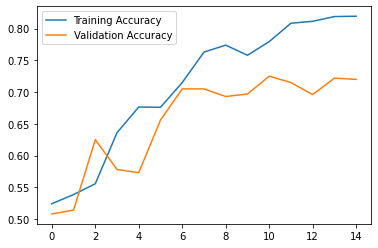

<IPython.core.display.Javascript object>

In [22]:
fig, ax = plt.subplots()
ax.plot(range(EPOCHS), history.history["accuracy"], label="Training Accuracy")
ax.plot(range(EPOCHS), history.history["val_accuracy"], label="Validation Accuracy")
ax.legend()
fig.show()

<ipython-input-23-65e0b284f8a7>:5: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


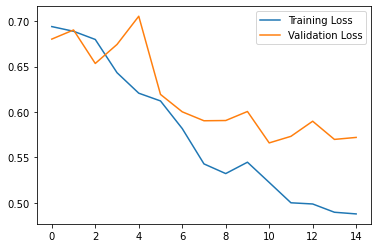

<IPython.core.display.Javascript object>

In [23]:
fig, ax = plt.subplots()
ax.plot(range(EPOCHS), history.history["loss"], label="Training Loss")
ax.plot(range(EPOCHS), history.history["val_loss"], label="Validation Loss")
ax.legend()
fig.show()